<a href="https://colab.research.google.com/github/kaisarmasum/Quantum-Machine-Learning/blob/main/Brain_Tumor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
%time

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 29.3 MB/s eta 0:00:00


In [ ]:
# QML
import pennylane as qml

# CML
import tensorflow as tf
from tensorflow import keras as K

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split


# for evaluation
from sklearn.metrics import classification_report
import itertools

# calculus
from pennylane import numpy as np

In [ ]:
# Counting labels
folder = "/content/gdrive/MyDrive/Colab Notebooks/data/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
for file in directs:
    f = h5py.File('/content/gdrive/MyDrive/Colab Notebooks/data/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(803,)

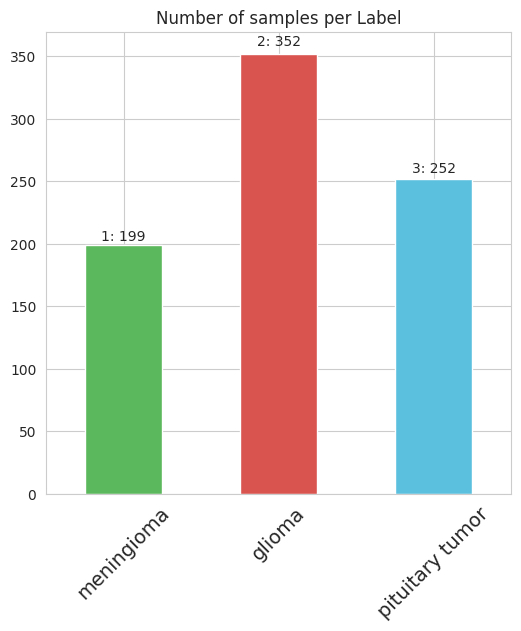

In [ ]:
# Tumor types
names = ["meningioma", "glioma", "pituitary tumor"]
# Count labels
labelcounts = labels.value_counts().sort_index()
# change the index with th types
labelcounts.index = names

#print(labelcounts)

# create a barchart
ax = labelcounts.plot(
        kind='bar',
        figsize=(6, 6),
        width=0.5,
        color=['#5cb85c', '#d9534f', '#5bc0de'],
     )

# define the title
ax.set_title("Number of samples per Label", size=12)
# change font size for labells an legend
plt.xticks(fontsize=14, rotation=45)

# putting the numbers
i = 1
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(i)+": "+str(height), (x + width/2, y + height*1.02), ha='center')
    i += 1

In [ ]:
folder = "/content/gdrive/MyDrive/Colab Notebooks/data/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
images = []
masks = []
for file in directs:
    f = h5py.File(folder+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    if label not in labels:
        #print(file)
        labels.append(label)
        img = np.stack((np.array(f.get("cjdata/image")),)*4, axis=-1)
        images.append(img)
        mask = np.array(f.get("cjdata/tumorMask"))
        masks.append(mask)
labels = np.asarray(labels)
images = np.asarray(images)
masks = np.asarray(masks)
labels.shape, images.shape, masks.shape

((3,), (3, 512, 512, 4), (3, 512, 512))

In [ ]:
b = K.utils.to_categorical(masks, num_classes=4).astype(np.uint8)
tumor = np.zeros_like(images[:, :, :, 1:])
image_norm = cv2.normalize(images[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

print(image_norm.shape)

# remove tumor part from image
tumor[:, :, :, 0] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 1] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 2] = image_norm * (b[:, :, :, 0])

# color tumor
tumor += b[:, :, :, 1:] * 255

tumor.shape

(3, 512, 512)


(3, 512, 512, 3)

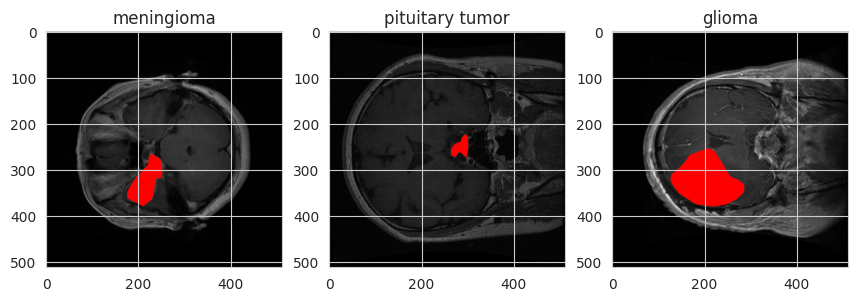

In [ ]:
fig = plt.figure(figsize=(14, 10))
for i in range(3):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(tumor[i], "gray")
    plt.title(names[int(labels[i]-1)])
plt.show()

In [ ]:
"""wires=4

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[3, 2])
    qml.CRZ(theta, wires=[2, 0])
    qml.CRX(theta, wires=[2, 0])


    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=0))

    return measurement


def QCONV1(X, image_number, image_total, step=4):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    out = np.zeros(((H//step), (W//step)))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # get nxn pixels and make them 1D array
            phi = X[i:i+step, j:j+step].flatten()
            # Get Measurement
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out

IndentationError: ignored

In [ ]:
"""import pennylane as qml
import numpy as np
wires=4

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)


def CONVCircuit(phi, wires):
    """
    Quantum convolution circuit for "n" wires
    """
    n = wires
    theta = np.pi / 2

    for i in range(n):
        qml.RX(phi[i] * np.pi, wires=i)

    for i in range(n - 1):
        qml.CRZ(theta, wires=[i + 1, i])
        qml.CRX(theta, wires=[i + 1, i])

    qml.CRZ(theta, wires=[n - 1, 0])
    qml.CRX(theta, wires=[n - 1, 0])

    # Expectation value (you can loop through wires to get measurements for each wire)
    measurements = [qml.expval(qml.PauliZ(wires=i)) for i in range(n)]

    return measurements


def QCONV1(X, image_number, image_total, step=wires):
    """
    Quantum convolutional layer
    """

    H, W = X.shape
    out = np.zeros(((H // step), (W // step)))

    for i in range(0, W, step):
        for j in range(0, H, step):
            # Get a subregion of the input image
            subregion = X[i:i+step, j:j+step]
            phi = subregion.flatten()
            # Apply the quantum convolution circuit to the subregion
            measurements = CONVCircuit(phi, len(phi))

            # Store the measurement in the output array
            out[i // step, j // step] = np.mean(measurements)  # You can adjust how you aggregate the measurements
            print(out)

    return out


IndentationError: ignored

In [ ]:
import pennylane as qml
import numpy as np

wires = 4

dev4 = qml.device("default.qubit", wires=wires)  # Define the simulator

@qml.qnode(dev4)
def CONVCircuit(phi):
    """
    Quantum convolution circuit for 2 wires
    """
    n = wires
    theta = np.pi / 2

    for i in range(n):
        qml.RX(phi[i] * np.pi, wires=i)

    for i in range(n - 1):
        qml.CRZ(theta, wires=[i + 1, i])
        qml.CRX(theta, wires=[i + 1, i])

    qml.CRZ(theta, wires=[n - 1, 0])
    qml.CRX(theta, wires=[n - 1, 0])

    # Expectation value (you can loop through wires to get measurements for each wire)
    measurements = [qml.expval(qml.PauliZ(wires=i)) for i in range(n)]

    return measurements

def QCONV1(X, image_number, image_total, step=wires):
    """
    Quantum convolutional layer
    """

    H, W = X.shape
    out = np.zeros(((H // step), (W // step)))

    for i in range(0, W, step):
        for j in range(0, H, step):
            # Get a subregion of the input image
            subregion = X[i:i+step, j:j+step]
            phi = subregion.flatten()
            # Apply the quantum convolution circuit to the subregion
            measurements = CONVCircuit(phi)

            # Store the measurement in the output array
            out[i // step, j // step] = np.mean(measurements)  # You can adjust how you aggregate the measurements

    return out


In [ ]:
phi = [1,1,1,1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi))

0: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─────────────────────────────────────────╭RZ(1.57)─╭RX(1.57)─┤  <Z>
1: ──RX(3.14)─╰●────────╰●────────╭RZ(1.57)─╭RX(1.57)─────────────────────│─────────│─────────┤  <Z>
2: ──RX(3.14)─────────────────────╰●────────╰●────────╭RZ(1.57)─╭RX(1.57)─│─────────│─────────┤  <Z>
3: ──RX(3.14)─────────────────────────────────────────╰●────────╰●────────╰●────────╰●────────┤  <Z>


In [ ]:
# Images processing with a Quantum Convolutional Layer after being resized
folder = "/content/gdrive/MyDrive/Colab Notebooks/data/" # .mat files folder
processFolder = "/content/gdrive/MyDrive/Colab Notebooks/processed/New/"
start = timer()
w = 512
step = 2
k = 0


directs = sorted(listdir(folder))

for file in directs:
    all64 = sorted(listdir(processFolder))
    if file+".npz" in all64:
        continue
    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    #resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
    NorImages = resized/255
    processed = QCONV1(NorImages, str(k)+" "+file, (len(directs)-len(all64))/2, step)
    #print(processed)
    np.savez_compressed(processFolder+file, image=processed, label=label)
    k+=1

end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

'0:29:56'

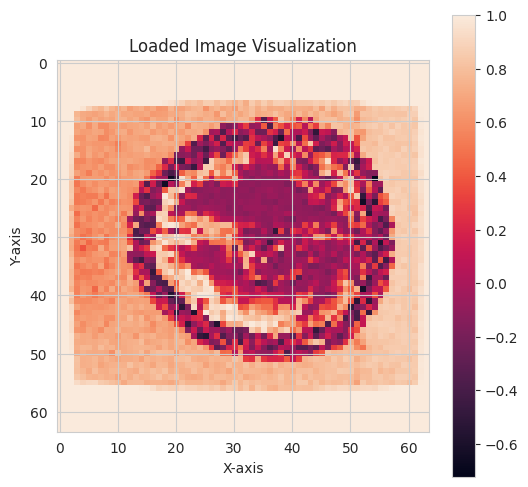

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image data
img = np.load("/content/gdrive/MyDrive/Colab Notebooks/processed/New/11.mat.npz")['image']

fig, ax = plt.subplots(figsize=(6, 6))


cax = ax.imshow(img)

cbar = fig.colorbar(cax, ax=ax)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Loaded Image Visualization')

plt.show()


In [ ]:
# get processed data
folder = "/content/gdrive/MyDrive/Colab Notebooks/processed/New/"
directs = sorted(listdir(folder))


images = []
masks = []
labels = []
i = 0
for file in directs:
    try:
        data = np.load(folder+file)
        label = data["label"]
        img = np.stack((data["image"],), axis=-1)
        images.append(img)
        labels.append(label)
        i+=1
    except:
        continue

npimages = np.asarray(images)
nplabels = np.asarray(labels)

In [ ]:
npimages.shape, nplabels.shape

((800, 64, 64, 1), (800,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [ ]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((560, 64, 64, 1), (120, 64, 64, 1), (120, 64, 64, 1), (120,), (560,), (120,))

In [ ]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        K.layers.Dropout(0.2),
        K.layers.Dense(4, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = Model()
checkpoint_path = "checkpoints/quantum.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=30,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/30
70/70 - 1s - loss: 1.6819 - accuracy: 0.8018 - val_loss: 1.5741 - val_accuracy: 0.8333 - 1s/epoch - 16ms/step
Epoch 2/30
70/70 - 0s - loss: 1.1745 - accuracy: 0.8857 - val_loss: 0.9635 - val_accuracy: 0.8833 - 310ms/epoch - 4ms/step
Epoch 3/30
70/70 - 0s - loss: 0.6943 - accuracy: 0.9607 - val_loss: 0.8136 - val_accuracy: 0.8917 - 288ms/epoch - 4ms/step
Epoch 4/30
70/70 - 0s - loss: 0.6049 - accuracy: 0.9571 - val_loss: 0.8315 - val_accuracy: 0.8833 - 327ms/epoch - 5ms/step
Epoch 5/30
70/70 - 0s - loss: 0.5090 - accuracy: 0.9804 - val_loss: 0.7637 - val_accuracy: 0.8833 - 311ms/epoch - 4ms/step
Epoch 6/30
70/70 - 0s - loss: 0.4616 - accuracy: 0.9768 - val_loss: 0.6476 - val_accuracy: 0.9000 - 288ms/epoch - 4ms/step
Epoch 7/30
70/70 - 0s - loss: 0.4532 - accuracy: 0.9625 - val_loss: 0.8195 - val_accuracy: 0.8833 - 279ms/epoch - 4ms/step
Epoch 8/30
70/70 - 0s - loss: 0.4158 - accuracy: 0.9750 - val_loss: 0.5869 - val_accuracy: 0.9333 - 278ms/epoch - 4ms/step
Epoch 9/30
70/70 -

In [ ]:
q_model.save('QModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Load the saved model from the file 'QModel.h5'
loaded_model = load_model('QModel.h5')

# Display the model architecture
loaded_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (8, 4096)                 0         
                                                                 
 dense_36 (Dense)            (8, 512)                  2097664   
                                                                 
 dropout_18 (Dropout)        (8, 512)                  0         
                                                                 
 dense_37 (Dense)            (8, 4)                    2052      
                                                                 
Total params: 2099716 (8.01 MB)
Trainable params: 2099716 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


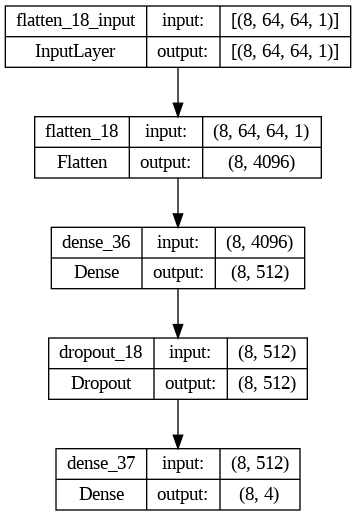

In [ ]:
from keras.utils import plot_model
plot_model(q_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

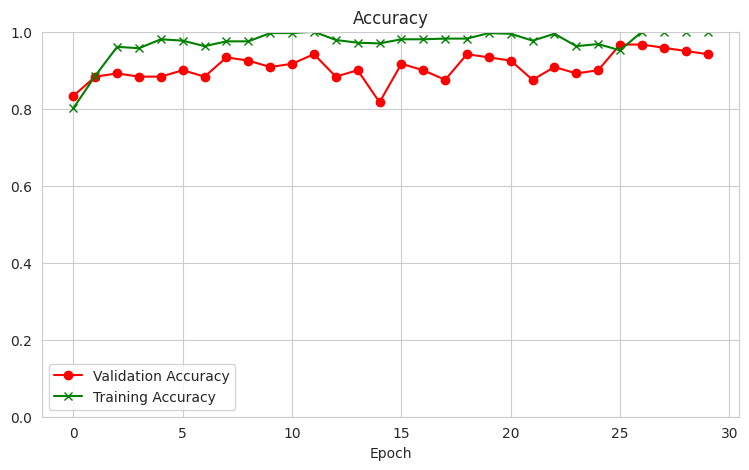

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

line_style = ['-o', '-x']
line_color = ['red', 'green']

# Create the first graph for accuracy
plt.figure(figsize=(9, 5))
plt.plot(q_history.history["val_accuracy"], line_style[0], label="Validation Accuracy", color=line_color[0])
plt.plot(q_history.history["accuracy"], line_style[1], label="Training Accuracy", color=line_color[1])
plt.ylim([0, 1])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

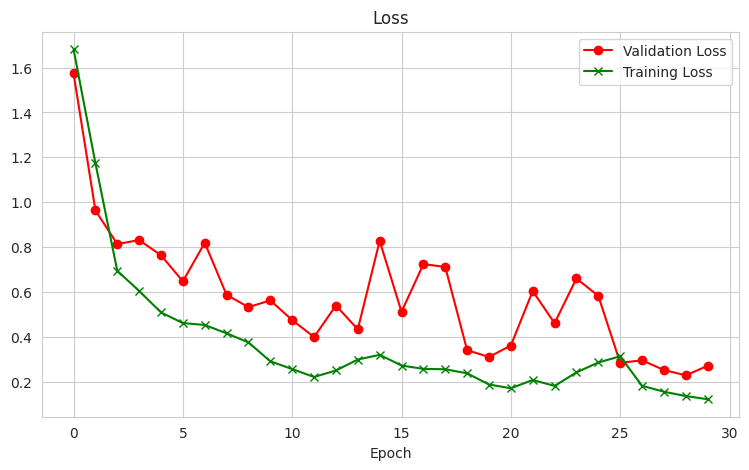

In [ ]:
# Create the second graph for loss
plt.figure(figsize=(9, 5))
plt.plot(q_history.history["val_loss"], line_style[0], label="Validation Loss", color=line_color[0])
plt.plot(q_history.history["loss"], line_style[1], label="Training Loss", color=line_color[1])
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Get Saved Model
q_model = K.models.load_model('QModel.h5')

In [ ]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

4/4 [==============================] - 0s 5ms/step


In [ ]:
yhat

array([2, 2, 2, 1, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 1, 1, 1, 2, 2, 3, 1, 1,
       3, 3, 1, 2, 3, 3, 2, 3, 2, 3, 1, 3, 2, 3, 3, 2, 1, 2, 2, 3, 3, 3,
       1, 1, 1, 3, 2, 2, 3, 1, 1, 2, 3, 2, 3, 1, 1, 1, 2, 1, 1, 3, 2, 2,
       3, 2, 3, 1, 1, 2, 1, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 1,
       3, 3, 1, 2, 2, 3, 1, 2, 2, 3, 2, 1, 2, 3, 3, 1, 1, 3, 3, 2, 3, 2,
       2, 3, 3, 1, 2, 2, 3, 2, 2, 1])

In [ ]:
yhat.shape, y_test.shape

((120,), (120,))

In [ ]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.97      0.97      0.97        32
         2.0       1.00      0.96      0.98        46
         3.0       0.95      1.00      0.98        42

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



In [ ]:
ytrain = q_model.predict(X_train)
ytrain = ytrain.argmax(axis=1)

18/18 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(y_train, ytrain))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       141
         2.0       1.00      1.00      1.00       248
         3.0       1.00      1.00      1.00       171

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560

